# stacking_fault_map_2D - Methodology and code

__Python imports__

- [numpy](http://www.numpy.org/)
- [IPython](https://ipython.org)
- [atomman](https://github.com/usnistgov/atomman)
- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from pathlib import Path
import shutil
import datetime
from copy import deepcopy
from math import floor
from typing import Optional, Tuple, Union

# http://www.numpy.org/
import numpy as np

# https://ipython.org/
from IPython.display import display, Markdown

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc
from atomman.tools import filltemplate

# https://github.com/usnistgov/iprPy
import iprPy
from iprPy.tools import read_calc_file

import matplotlib.pyplot as plt

print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2024-05-02 using iprPy version 0.11.7


## 1. Load calculation and view description

### 1.1. Load the calculation

In [2]:
# Load the calculation being demoed
calculation = iprPy.load_calculation('stacking_fault_map_2D')

### 1.2. Display calculation description and theory

In [3]:
# Display main docs and theory
display(Markdown(calculation.maindoc))
display(Markdown(calculation.theorydoc))

# stacking_fault_map_2D calculation style

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

## Introduction

The stacking_fault_map_2D calculation style evaluates the full 2D generalized stacking fault map for an array of shifts along a specified crystallographic plane.  A regular grid of points is established and the generalized stacking fault energy is evaluated at each.

### Version notes

- 2018-07-09: Notebook added.
- 2019-07-30: Description updated and small changes due to iprPy version.
- 2020-05-22: Version 0.10 update - potentials now loaded from database.
- 2020-09-22: Calculation updated to use atomman.defect.StackingFault class. Setup and parameter definition streamlined.
- 2022-03-11: Notebook updated to reflect version 0.11.

### Additional dependencies

### Disclaimers

- [NIST disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)
- The system's dimension perpendicular to the fault plane should be large to minimize the interaction of the free surface and the stacking fault.


## Method and Theory

First, an initial system is generated.  This is accomplished using atomman.defect.StackingFault, which

1. Starts with a unit cell system.

2. Generates a transformed system by rotating the unit cell such that the new
   system's box vectors correspond to crystallographic directions, and filled
   in with atoms to remain a perfect bulk cell when the three boundaries are
   periodic.

3. All atoms are shifted by a fractional amount of the box vectors if needed.

4. A supercell system is constructed by combining multiple replicas of the
   transformed system.

5. The system is then cut by making one of the box boundaries non-periodic.  A limitation placed on the calculation is that the normal to the cut plane must correspond to one of the three Cartesian ($x$, $y$, or $z$) axes.  If true, then of the system's three box vectors ($\vec{a}$, $\vec{b}$, and $\vec{c}$), two will be parallel to the plane, and the third will not.  The non-parallel box vector is called the cutboxvector, and for LAMMPS compatible systems, the following conditions can be used to check the system's compatibility:

   - cutboxvector = 'c': all systems allowed.

   - cutboxvector = 'b': the system's yz tilt must be zero.

   - cutboxvector = 'a': the system's xy and xz tilts must be zero.

A LAMMPS simulation performs an energy/force minimization on the system where the atoms are confined to only relax along the Cartesian direction normal to the cut plane.

A mathematical fault plane parallel to the cut plane is defined in the middle of the system.  A generalized stacking fault system can then be created by shifting all atoms on one side of the fault plane by a vector, $\vec{s}$.  The shifted system is then relaxed using the same confined energy/force minimization used on the non-shifted system.  The generalized stacking fault energy, $\gamma$, can then be computed by comparing the total energy of the system, $E_{total}$, before and after $\vec{s}$ is applied

$$ \gamma(\vec{s}) = \frac{E_{total}(\vec{s}) - E_{total}(\vec{0})}{A},$$

where $A$ is the area of the fault plane, which can be computed using the two box vectors, $\vec{a_1}$ and $\vec{a_2}$, that are not the cutboxvector.

$$A = \left| \vec{a_1} \times \vec{a_2} \right|,$$

Additionally, the relaxation normal to the glide plane is characterized using the center of mass of the atoms above and below the cut plane.  Notably, the component of the center of mass normal to the glide/cut plane is calculated for the two halves of the the system, and the difference is computed

$$ \delta = \left<x\right>^{+} - \left<x\right>^{-}.$$

The relaxation normal is then taken as the change in the center of mass difference after the shift is applied.

$$ \Delta\delta = \delta(\vec{s}) - \delta(\vec{0}).$$

The stacking_fault_map_2D calculation evaluates both $\gamma$ and $\Delta\delta$ for a complete 2D grid of $\vec{s}$ values.  The grid is built by taking fractional steps along two vectors parallel to the shift plane.


## 2. Define calculation functions and generate files

This section defines the calculation functions and associated resource files exactly as they exist inside the iprPy package.  This allows for the code used to be directly visible and modifiable by anyone looking to see how it works.

### 2.1. stackingfaultmap()

This is the primary function for the calculation.  The version of this function built in iprPy can be accessed by calling the calc() method of an object of the associated calculation class.

In [4]:
def stackingfaultmap(lammps_command: str,
                     ucell: am.System,
                     potential: lmp.Potential,
                     hkl: Union[list, np.ndarray],
                     mpi_command: Optional[str] = None,
                     sizemults: Union[list, tuple, None] = None,
                     minwidth: float = None,
                     even: bool = False,
                     a1vect_uvw: Union[list, np.ndarray, None] = None,
                     a2vect_uvw: Union[list, np.ndarray, None] = None,
                     conventional_setting: str = 'p',
                     cutboxvector: str = 'c',
                     faultpos_rel: Optional[float] = None,
                     faultpos_cart: Optional[float] = None,
                     num_a1: int = 10,
                     num_a2: int = 10,
                     atomshift: Union[list, np.ndarray, None] = None,
                     shiftindex: Optional[int] = None,
                     etol: float = 0.0,
                     ftol: float = 0.0,
                     maxiter: int = 10000,
                     maxeval: int = 100000,
                     dmax: float = uc.set_in_units(0.01, 'angstrom')) -> dict:
    """
    Computes a generalized stacking fault map for shifts along a regular 2D
    grid.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    ucell : atomman.System
        The crystal unit cell to use as the basis of the stacking fault
        configurations.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    hkl : array-like object
        The Miller(-Bravais) crystal fault plane relative to ucell.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    sizemults : list or tuple, optional
        The three System.supersize multipliers [a_mult, b_mult, c_mult] to use on the
        rotated cell to build the final system. Note that the cutboxvector sizemult
        must be an integer and not a tuple.  Default value is [1, 1, 1].
    minwidth : float, optional
        If given, the sizemult along the cutboxvector will be selected such that the
        width of the resulting final system in that direction will be at least this
        value. If both sizemults and minwidth are given, then the larger of the two
        in the cutboxvector direction will be used. 
    even : bool, optional
        A True value means that the sizemult for cutboxvector will be made an even
        number by adding 1 if it is odd.  Default value is False.
    a1vect_uvw : array-like object, optional
        The crystal vector to use for one of the two shifting vectors.  If
        not given, will be set to the shortest in-plane lattice vector.
    a2vect_uvw : array-like object, optional
        The crystal vector to use for one of the two shifting vectors.  If
        not given, will be set to the shortest in-plane lattice vector not
        parallel to a1vect_uvw.
    conventional_setting : str, optional
        Allows for rotations of a primitive unit cell to be determined from
        (hkl) indices specified relative to a conventional unit cell.  Allowed
        settings: 'p' for primitive (no conversion), 'f' for face-centered,
        'i' for body-centered, and 'a', 'b', or 'c' for side-centered.  Default
        behavior is to perform no conversion, i.e. take (hkl) relative to the
        given ucell.
    cutboxvector : str, optional
        Indicates which of the three system box vectors, 'a', 'b', or 'c', to
        cut with a non-periodic boundary (default is 'c').
    faultpos_rel : float, optional
        The position to place the slip plane within the system given as a
        relative coordinate along the out-of-plane direction.  faultpos_rel
        and faultpos_cart cannot both be given.  Default value is 0.5 if 
        faultpos_cart is also not given.
    faultpos_cart : float, optional
        The position to place the slip plane within the system given as a
        Cartesian coordinate along the out-of-plane direction.  faultpos_rel
        and faultpos_cart cannot both be given.
    num_a1 : int, optional
        The number of fractional coordinates to evaluate along a1vect_uvw.
        Default value is 10.
    num_a2 : int, optional
        The number of fractional coordinates to evaluate along a2vect_uvw.
        Default value is 10.
    atomshift : array-like object, optional
        A Cartesian vector shift to apply to all atoms.  Can be used to shift
        atoms perpendicular to the fault plane to allow different termination
        planes to be cut.  Cannot be given with shiftindex.
    shiftindex : int, optional
        Allows for selection of different termination planes based on the
        preferred shift values determined by the underlying fault generation.
        Cannot be given with atomshift. If neither atomshift nor shiftindex
        given, then shiftindex will be set to 0.
    etol : float, optional
        The energy tolerance for the structure minimization. This value is
        unitless. (Default is 0.0).
    ftol : float, optional
        The force tolerance for the structure minimization. This value is in
        units of force. (Default is 0.0).
    maxiter : int, optional
        The maximum number of minimization iterations to use (default is 
        10000).
    maxeval : int, optional
        The maximum number of minimization evaluations to use (default is 
        100000).
    dmax : float, optional
        The maximum distance in length units that any atom is allowed to relax
        in any direction during a single minimization iteration (default is
        0.01 Angstroms).
    
    Returns
    -------
    dict
        Dictionary of results consisting of keys:
        
        - **'A_fault'** (*float*) - The area of the fault surface.
        - **'gamma'** (*atomman.defect.GammaSurface*) - A gamma surface
          plotting object.
    """
    # Construct stacking fault configuration generator
    gsf_gen = am.defect.StackingFault(hkl, ucell, cutboxvector=cutboxvector,
                                      a1vect_uvw=a1vect_uvw, a2vect_uvw=a2vect_uvw,
                                      conventional_setting=conventional_setting)
    
    # Check shift parameters
    if shiftindex is not None:
        assert atomshift is None, 'shiftindex and atomshift cannot both be given'
        atomshift = gsf_gen.shifts[shiftindex]
    elif atomshift is None:
        atomshift = gsf_gen.shifts[0]
    
    # Generate the free surface (zero-shift) configuration
    gsf_gen.surface(shift=atomshift, minwidth=minwidth, sizemults=sizemults,
                    even=even, faultpos_rel=faultpos_rel,
                    faultpos_cart=faultpos_cart)
    
    abovefault = gsf_gen.abovefault
    cutindex = gsf_gen.cutindex
    A_fault = gsf_gen.surfacearea

    # Identify lammps_date version
    lammps_date = lmp.checkversion(lammps_command)['date']
    
    # Define lists
    a1vals = []
    a2vals = []
    E_totals = []
    disps = []

    # Loop over all shift combinations
    for a1, a2, sfsystem in gsf_gen.iterfaultmap(num_a1=num_a1, num_a2=num_a2):
        a1vals.append(a1)
        a2vals.append(a2)

        # Evaluate the system at the shift
        sim_directory = Path('a%.10f-b%.10f' % (a1, a2))
        relax = stackingfaultrelax(lammps_command, sfsystem, potential,
                                   mpi_command=mpi_command, 
                                   sim_directory=sim_directory,
                                   cutboxvector=cutboxvector,
                                   etol=etol, ftol=ftol, maxiter=maxiter,
                                   maxeval=maxeval, dmax=dmax,
                                   lammps_date=lammps_date)
        
        # Extract terms
        E_totals.append(relax['E_total'])
        pos = relax['system'].atoms.pos
        disps.append(pos[abovefault, cutindex].mean()
                   - pos[~abovefault, cutindex].mean())
    
    E_totals = np.array(E_totals)
    disps = np.array(disps)
    
    # Get zeroshift values
    E_total_0 = E_totals[0]
    disp_0 = disps[0]
    
    # Compute the stacking fault energies
    E_gsfs = (E_totals - E_total_0) / A_fault
    
    # Compute the change in displacement normal to fault plane
    delta_disps = disps - disp_0
    
    results_dict = {}
    results_dict['A_fault'] = A_fault
    results_dict['gamma'] = am.defect.GammaSurface(a1vect = gsf_gen.a1vect_uvw,
                                                   a2vect = gsf_gen.a2vect_uvw,
                                                   box = gsf_gen.ucell.box,
                                                   a1 = a1vals,
                                                   a2 = a2vals,
                                                   E_gsf = E_gsfs,
                                                   delta = delta_disps)

    return results_dict

### 2.2. stackingfaultrelax()

In [5]:
def stackingfaultrelax(lammps_command: str,
                       system: am.System,
                       potential: lmp.Potential,
                       mpi_command: Optional[str] = None,
                       sim_directory: Optional[str] = None,
                       cutboxvector: str = 'c',
                       etol: float = 0.0,
                       ftol: float = 0.0,
                       maxiter: int = 10000,
                       maxeval: int = 100000,
                       dmax: float = uc.set_in_units(0.01, 'angstrom'),
                       lammps_date: Optional[datetime.date] = None) -> dict:
    """
    Perform a stacking fault relaxation simulation for a single faultshift.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    system : atomman.System
        The system containing a stacking fault.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    sim_directory : str, optional
        The path to the directory to perform the simulation in.  If not
        given, will use the current working directory.
    cutboxvector : str, optional
        Indicates which of the three system box vectors, 'a', 'b', or 'c', has
        the non-periodic boundary (default is 'c').  Fault plane normal is
        defined by the cross of the other two box vectors.
    etol : float, optional
        The energy tolerance for the structure minimization. This value is
        unitless. (Default is 0.0).
    ftol : float, optional
        The force tolerance for the structure minimization. This value is in
        units of force. (Default is 0.0).
    maxiter : int, optional
        The maximum number of minimization iterations to use (default is 
        10000).
    maxeval : int, optional
        The maximum number of minimization evaluations to use (default is 
        100000).
    dmax : float, optional
        The maximum distance in length units that any atom is allowed to relax
        in any direction during a single minimization iteration (default is
        0.01 Angstroms).
    lammps_date : datetime.date or None, optional
        The date version of the LAMMPS executable.  If None, will be identified
        from the lammps_command (default is None).
    
    Returns
    -------
    dict
        Dictionary of results consisting of keys:
        
        - **'logfile'** (*str*) - The filename of the LAMMPS log file.
        - **'dumpfile'** (*str*) - The filename of the LAMMPS dump file
          of the relaxed system.
        - **'system'** (*atomman.System*) - The relaxed system.
        - **'E_total'** (*float*) - The total potential energy of the relaxed
          system.
    
    Raises
    ------
    ValueError
        For invalid cutboxvectors.
    """
    
    # Give correct LAMMPS fix setforce command
    if cutboxvector == 'a':
        fix_cut_setforce = 'fix cut all setforce NULL 0 0'    
    elif cutboxvector == 'b':
        fix_cut_setforce = 'fix cut all setforce 0 NULL 0'
    elif cutboxvector == 'c':
        fix_cut_setforce = 'fix cut all setforce 0 0 NULL'    
    else: 
        raise ValueError('Invalid cutboxvector')
    
    if sim_directory is not None:
        # Create sim_directory if it doesn't exist
        sim_directory = Path(sim_directory)
        if not sim_directory.is_dir():
            sim_directory.mkdir()
        sim_directory = sim_directory.as_posix()+'/'
    else:
        # Set sim_directory if is None
        sim_directory = ''
    
    # Get lammps units
    lammps_units = lmp.style.unit(potential.units)
    
    #Get lammps version date
    if lammps_date is None:
        lammps_date = lmp.checkversion(lammps_command)['date']
    
    # Define lammps variables
    lammps_variables = {}
    system_info = system.dump('atom_data',
                              f=Path(sim_directory, 'system.dat').as_posix(),
                              potential=potential)
    lammps_variables['atomman_system_pair_info'] = system_info
    lammps_variables['fix_cut_setforce'] = fix_cut_setforce
    lammps_variables['sim_directory'] = sim_directory
    lammps_variables['etol'] = etol
    lammps_variables['ftol'] = uc.get_in_units(ftol, lammps_units['force'])
    lammps_variables['maxiter'] = maxiter
    lammps_variables['maxeval'] = maxeval
    lammps_variables['dmax'] = uc.get_in_units(dmax, lammps_units['length'])
    
    # Set dump_modify format based on dump_modify_version
    if lammps_date < datetime.date(2016, 8, 3):
        lammps_variables['dump_modify_format'] = '"%i %i %.13e %.13e %.13e %.13e"'
    else:
        lammps_variables['dump_modify_format'] = 'float %.13e'
    
    # Write lammps input script
    lammps_script = Path(sim_directory, 'sfmin.in')
    template = read_calc_file('iprPy.calculation.stacking_fault_map_2D',
                              'sfmin.template')
    with open(lammps_script, 'w') as f:
        f.write(filltemplate(template, lammps_variables, '<', '>'))
    
    # Run LAMMPS
    output = lmp.run(lammps_command, script_name=lammps_script.as_posix(),
                     mpi_command=mpi_command,
                     logfile=Path(sim_directory, 'log.lammps').as_posix())
    
    # Extract output values
    thermo = output.simulations[-1]['thermo']
    logfile = Path(sim_directory, 'log.lammps').as_posix()
    dumpfile = Path(sim_directory, '%i.dump' % thermo.Step.values[-1]).as_posix()
    E_total = uc.set_in_units(thermo.PotEng.values[-1],
                              lammps_units['energy'])
    
    # Load relaxed system
    system = am.load('atom_dump', dumpfile, symbols=system.symbols)
    
    # Return results
    results_dict = {}
    results_dict['logfile'] = logfile
    results_dict['dumpfile'] = dumpfile
    results_dict['system'] = system
    results_dict['E_total'] = E_total
    
    return results_dict

### 2.3. sfmin.template file

In [6]:
with open('sfmin.template', 'w') as f:
    f.write("""#LAMMPS input script that performs an energy minimization
#for a system with a stacking fault

box tilt large

<atomman_system_pair_info>

<fix_cut_setforce>

thermo_style custom step lx ly lz pxx pyy pzz pe
thermo_modify format float %.13e

compute peatom all pe/atom 

min_modify dmax <dmax>

dump dumpit all custom <maxeval> <sim_directory>*.dump id type x y z c_peatom
dump_modify dumpit format <dump_modify_format>

minimize <etol> <ftol> <maxiter> <maxeval>""")

## 3. Specify input parameters

### 3.1. System-specific paths

- __lammps_command__ is the LAMMPS command to use (required).
- __mpi_command__ MPI command for running LAMMPS in parallel. A value of None will run simulations serially.

In [7]:
lammps_command = '/home/lmh1/LAMMPS/2022-06-23/src/lmp_serial'
mpi_command = None

# Optional: check that LAMMPS works and show its version 
print(f'LAMMPS version = {am.lammps.checkversion(lammps_command)["version"]}')

LAMMPS version = 23 Jun 2022


### 3.2. Interatomic potential

- __potential_name__ gives the name of the potential_LAMMPS reference record in the iprPy library to use for the calculation.  
- __potential__ is an atomman.lammps.Potential object (required).

In [8]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'

# Retrieve potential and parameter file(s) using atomman
potential = am.load_lammps_potential(id=potential_name, getfiles=True)

### 3.3. Initial unit cell system

- __ucell__ is an atomman.System representing a fundamental unit cell of the system (required).  Here, this is generated using the load parameters and symbols.

In [9]:
# Create ucell by loading prototype record
ucell = am.load('crystal', potential=potential, family='A1--Cu--fcc')

print(ucell)

Multiple matching record retrieved from local
#  family               symbols  alat    Ecoh    method  standing
 1 A1--Cu--fcc          Ni        3.5200 -4.4500 dynamic good
 2 A1--Cu--fcc          Ni        7.3760  0.0119 dynamic good


Please select one: 1


avect =  [ 3.520,  0.000,  0.000]
bvect =  [ 0.000,  3.520,  0.000]
cvect =  [ 0.000,  0.000,  3.520]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Ni',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   1.760 |   1.760
      2 |       1 |   1.760 |   0.000 |   1.760
      3 |       1 |   1.760 |   1.760 |   0.000


### 3.4. Defect parameters

- __hkl__ gives the Miller (hkl) or Miller-Bravais (hkil) plane to create the free surface on.

- __cutboxvector__ specifies which of the three box vectors ('a', 'b', or 'c') is to be made non-periodic to create the free surface. 

- __shiftindex__ can be used for complex crystals to specify different termination planes.

- __a1vect_uvw, a2vect_uvw__ specify two non-parallel Miller crystal vectors within the fault plane corresponding to full planar shifts from one perfect crystal configuration to another.  

- __num_a1, num_a2__ specify how many measurements to make along a1vect_uvw, a2vect_uvw respectively.

In [10]:
hkl = [1, 1, 1]
cutboxvector = 'c'
shiftindex = 0
a1vect_uvw = [ 0.0,-0.5, 0.5]
a2vect_uvw = [ 0.5,-0.5, 0.0]
num_a1 = 30
num_a2 = 30

### 3.5. System modifications

- __sizemults__  list of three integers specifying how many times the ucell vectors of $a$, $b$ and $c$ are replicated in creating system.
- __minwidth__ specifies a minimum width that the system should be along the cutboxvector direction. The given sizemult in that direction will be increased if needed to ensure that the system is at least this wide. 

In [11]:
sizemults = [5, 5, 10]
minwidth = uc.set_in_units(0.0, 'angstrom')

### 3.5. Calculation-specific parameters

- __energytolerance__ is the energy tolerance to use during the minimizations. This is unitless.

- __forcetolerance__ is the force tolerance to use during the minimizations. This is in energy/length units.

- __maxiterations__ is the maximum number of minimization iterations to use.

- __maxevaluations__ is the maximum number of minimization evaluations to use.

- __maxatommotion__ is the largest distance that an atom is allowed to move during a minimization iteration. This is in length units.

In [12]:
energytolerance = 1e-8
forcetolerance = uc.set_in_units(0.0, 'eV/angstrom')
maxiterations = 10000
maxevaluations = 100000
maxatommotion = uc.set_in_units(0.01, 'angstrom')

## 4. Run calculation and view results

### 4.1. Run calculation

All primary calculation method functions take a series of inputs and return a dictionary of outputs.

In [13]:
results_dict = stackingfaultmap(lammps_command, ucell, potential, hkl,
                                mpi_command = mpi_command,
                                sizemults = sizemults,
                                minwidth = minwidth,
                                a1vect_uvw = a1vect_uvw,
                                a2vect_uvw = a2vect_uvw,
                                cutboxvector = cutboxvector,
                                shiftindex = shiftindex,
                                num_a1 = num_a1,
                                num_a2 = num_a2, 
                                etol = energytolerance,
                                ftol = forcetolerance,
                                maxiter = maxiterations,
                                maxeval = maxevaluations,
                                dmax = maxatommotion)
print(results_dict.keys())

dict_keys(['A_fault', 'gamma'])


### 4.2. Report results

Values returned in the results_dict:

- **'A_fault'** (*float*) - The area of the fault surface.
- **'gamma'** (*atomman.defect.GammaSurface*) - A gamma surface
  plotting object.

In [14]:
length_unit = 'nm'
area_unit = 'nm^2'
energy_unit = 'eV'
energyperarea_unit = 'mJ/m^2'

In [15]:
print('A_fault =', uc.get_in_units(results_dict['A_fault'], area_unit), area_unit)

A_fault = 5.365198866947918 nm^2


In [16]:
gamma = results_dict['gamma']
print(gamma.a1vect)
print(gamma.a2vect)

[ 0.  -0.5  0.5]
[ 0.5 -0.5  0. ]


In [17]:
# Save gamma as data model
with open('gamma.json', 'w') as f:
    gamma.model().json(fp=f, indent=4)

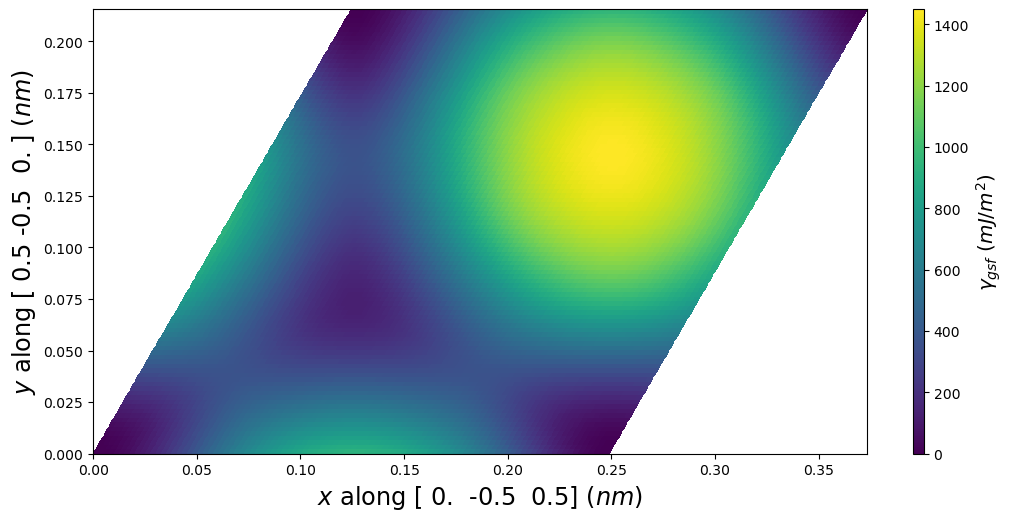

In [18]:
# Plot with calculation a1vect, a2vect
gamma.E_gsf_surface_plot(length_unit=length_unit,
                         energyperarea_unit=energyperarea_unit)
plt.show()

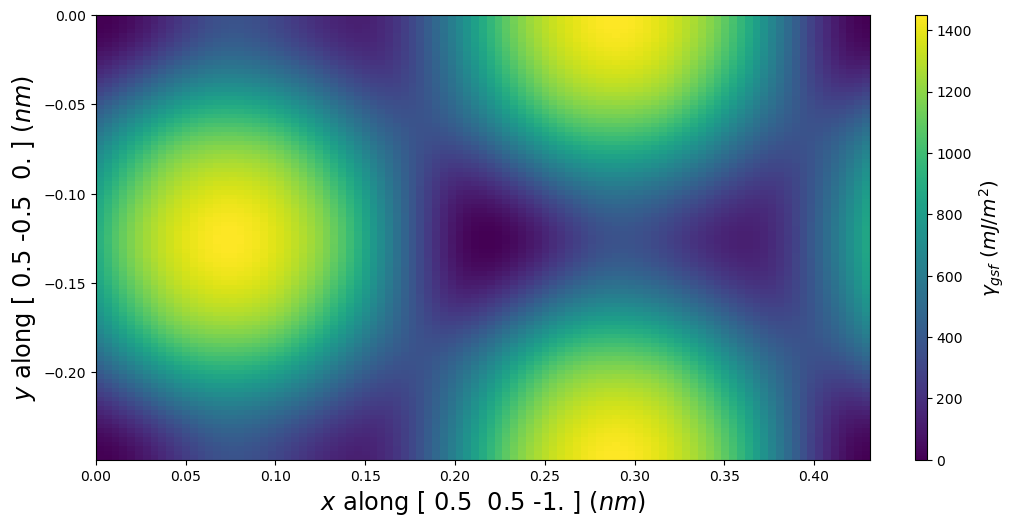

In [19]:
# Plot with standard A1--fcc--111sf a1vect, a2vect
gamma.E_gsf_surface_plot(a1vect=[0.5, 0.5, -1],
                         a2vect=gamma.a2vect,
                         length_unit=length_unit,
                         energyperarea_unit=energyperarea_unit)
plt.show()

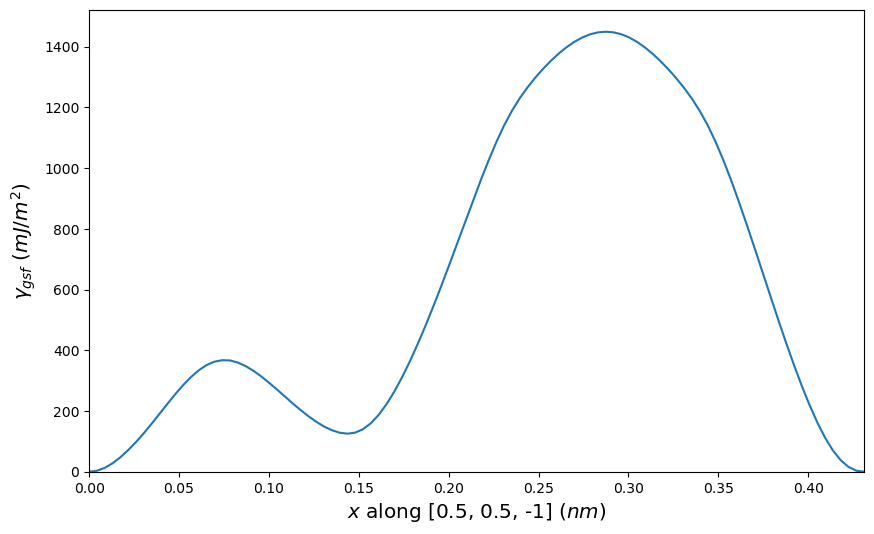

In [20]:
# Standard 1D [11-2](111) fcc path
gamma.E_gsf_line_plot(vect=[0.5, 0.5, -1], length_unit=length_unit,
                      energyperarea_unit=energyperarea_unit)
plt.show()